# Toxic Comment Classification

The objective of this notebook is to build a multi-headed model that is capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate using a dataset of comments from Wikipedia’s talk page edits, sourced from Kaggle. The models that are built and evaluated are probabilistic learning methods like Logistic Regression and Naive Bayes that are commonly used for text classification.

##### Loading necessary packages

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import demoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [90]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emaanbilal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emaanbilal/nltk_data...


True

### Data Preprocessing and EDA

##### 📥 Loading the data

The first step involves loading and preprocessing data. We read training and testing data from CSV files, extract relevant labels and comments, filter out rows with invalid labels (those rows that are excluded from scoring, as per official documentation), and reset the index for further data manipulation. The target is a vector which contains six categories. This is identified a multiclass multilabel classification problem.

This prepares the dataset for us to explore, and subsequently build models for. 

In [12]:
train = pd.read_csv("dataset/train.csv")
train_y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
train_x = train[['comment_text']]
test_x = pd.read_csv("dataset/test.csv")
test_y = pd.read_csv("dataset/test_labels.csv")
df_test = pd.merge(test_x, test_y, on="id")
mask = (df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)
test_all = df_test[mask]
test_all.reset_index(drop=True, inplace=True)
test_y = test_all[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_x = test_all[['comment_text']]

##### 🧭 Data Cleaning and Exploration

Next, we check whether the training data has any null values which can potentially impact our subsequent data models.

In [75]:
def null_percentage(column):
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    return perc

def check_null(df, columns):
    results = {}
    for col in columns:
        result = null_percentage(df[col])
        results[col] = result
    return results

null_results = check_null(train_x, train_x.columns)
for col, result in null_results.items():
    print(f'{result}% missing from {col} column in training data.')

0% missing from comment_text column in training data.


No missing data is found, and so we proceed with trying to understand the data. 

In [76]:
print(train_x.shape)
train_x.head()

(159571, 1)


,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


In [77]:
print(train_y.shape)
train_y.head()


(159571, 6)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [78]:
print(test_x.shape)
test_x.head()

(63978, 1)


,comment_text
0,Thank you for understanding. I think very high...
1,:Dear god this site is horrible.
2,"""::: Somebody will invariably try to add Relig..."
3,""" \n\n It says it right there that it IS a typ..."
4,""" \n\n == Before adding a new product to the l..."


In [79]:
print(test_y.shape)
test_y.head()

(63978, 6)


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


We notice that the training data contains 159,571 observations and the test data contains 63,978 observations. We see the utilization of one-hot encoding in the context of multilabel datasets, where each possible label has its own column, and is assigned a binary 1 to indicate its presence in the observed comment. is either assigned one of the following labels: "toxic", "severe_toxic", "obscene", "threat", "insult", or "identity_hate." If a comment is not categorized in any of the 6 categories, it is considered non-toxic or clean.


##### 📊 Data Visualization

Next, we explore the data by visualizing it to better understand what kind of dataset we are dealing with, so as to inform further model building.


Below is a plot that shows the comment length distribution. We can see most of the comments are short with only a few comments longer than 1000 words, indicating that long term dependencies may be few, and suggesting that a simpler model architecture could be effective.

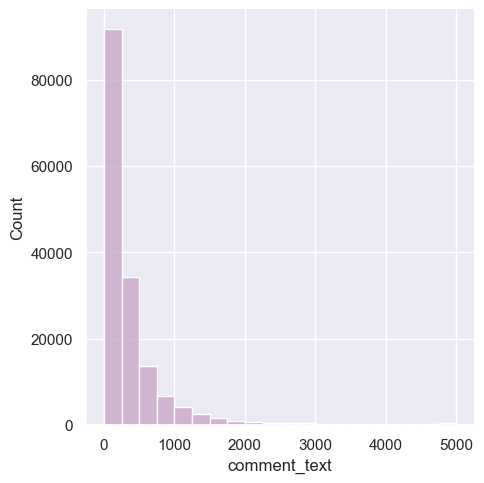

In [80]:
sns.set(color_codes=True)
comment_len = train_x.comment_text.str.len()
sns.displot(comment_len, kde=False, bins=20, color="#c8a2c8")


Next we observe what the distribution of the occurrence of labels looks like in the dataset. We can see that the label toxic has the most observations in the training dataset while threat has the least. This class imbalance may impact any model's ability to generalize well across all classes, and so our evaluation of models should account for this, moving forward. 


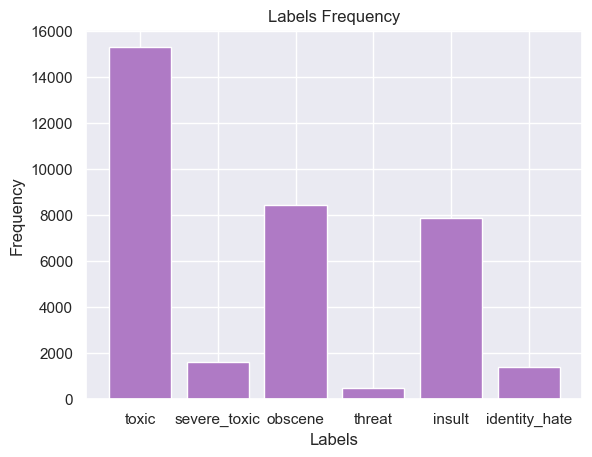

In [81]:
labels = train_y[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
label_count = labels.sum()

plt.bar(label_count.index, label_count, color='#af7ac5')
plt.title('Labels Frequency')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()


Seeing that data is not balanced across toxic classes, we wish to observe how instances are distributed between labeled and unlabeled classes for each label type in the dataset. This will help in understanding the balance or imbalance in the dataset with respect to different labels and assess if we have suffiicient data for accurate modelling and prediction. Below, after plotting the frequency of labelled data vs unlabelled, we find that an overwhelming amount of comments labelled as non-toxic, disproportionate with respect to the frequency of each label. This suggests there is a risk of model bias towards the majority class (non-toxic). The model may learn to predict non-toxic labels well but may perform poorly on toxic comments, as it has less exposure to them. As a result, accuracy alone may not be an informative metric because a classifier predicting all instances as non-toxic could still achieve a high accuracy. It's essential to consider precision, recall, and F1-score, especially for minority classes (toxic comments), for future modelling.


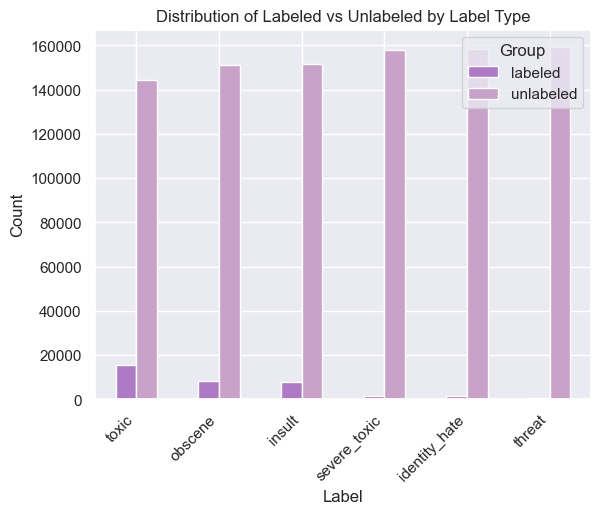

In [82]:
label_columns = ['toxic', 'obscene', 'insult', 'severe_toxic', 'identity_hate', 'threat']

bars1 = [train_y[label].sum() for label in label_columns]
bars2 = [len(train_y) - label_sum for label_sum in bars1]

df_bars = pd.DataFrame({'labeled': bars1, 'unlabeled': bars2}, index=label_columns)

ax = df_bars.plot(kind='bar', color=['#af7ac5', '#c8a2c8'])
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labeled vs Unlabeled by Label Type')
ax.legend(title='Group')
ax.set_xticklabels(label_columns, rotation=45, ha='right')

plt.show()

Nect we visualize correlations between different labels to see which labels are likely to appear together with a comment. As seen below, toxic comments are likely to co occur with obscene ones, and there is also a strong correlation between obscene and toxic comments. This multicollinearity can impact model stability, and makes precision and recall metrics crucial in evaluating model performance, as it helps assess how well the model identifies true positives while minimizing false positives or false negatives.

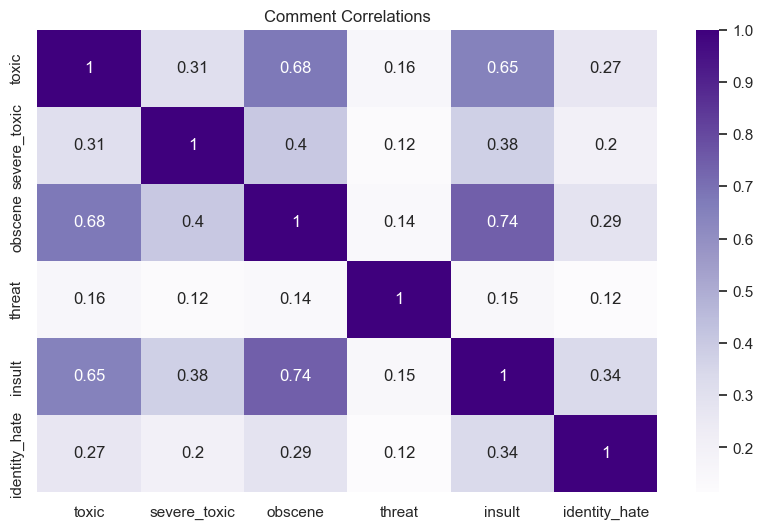

In [83]:
plt.figure(figsize=(10, 6))
correlation = train_y[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()
sns.heatmap(correlation, annot=True, cmap='Purples')
plt.title('Comment Correlations')
plt.show()

Next, we build wordclouds for each label in the toxic comments as well as the clean comments to get an idea of the words that contribute the most to different labels. Similarity is seen between words in obscene, toxic and insult categories, corroborating the correlation values above. There is a marked difference with the words common in clean instances. 

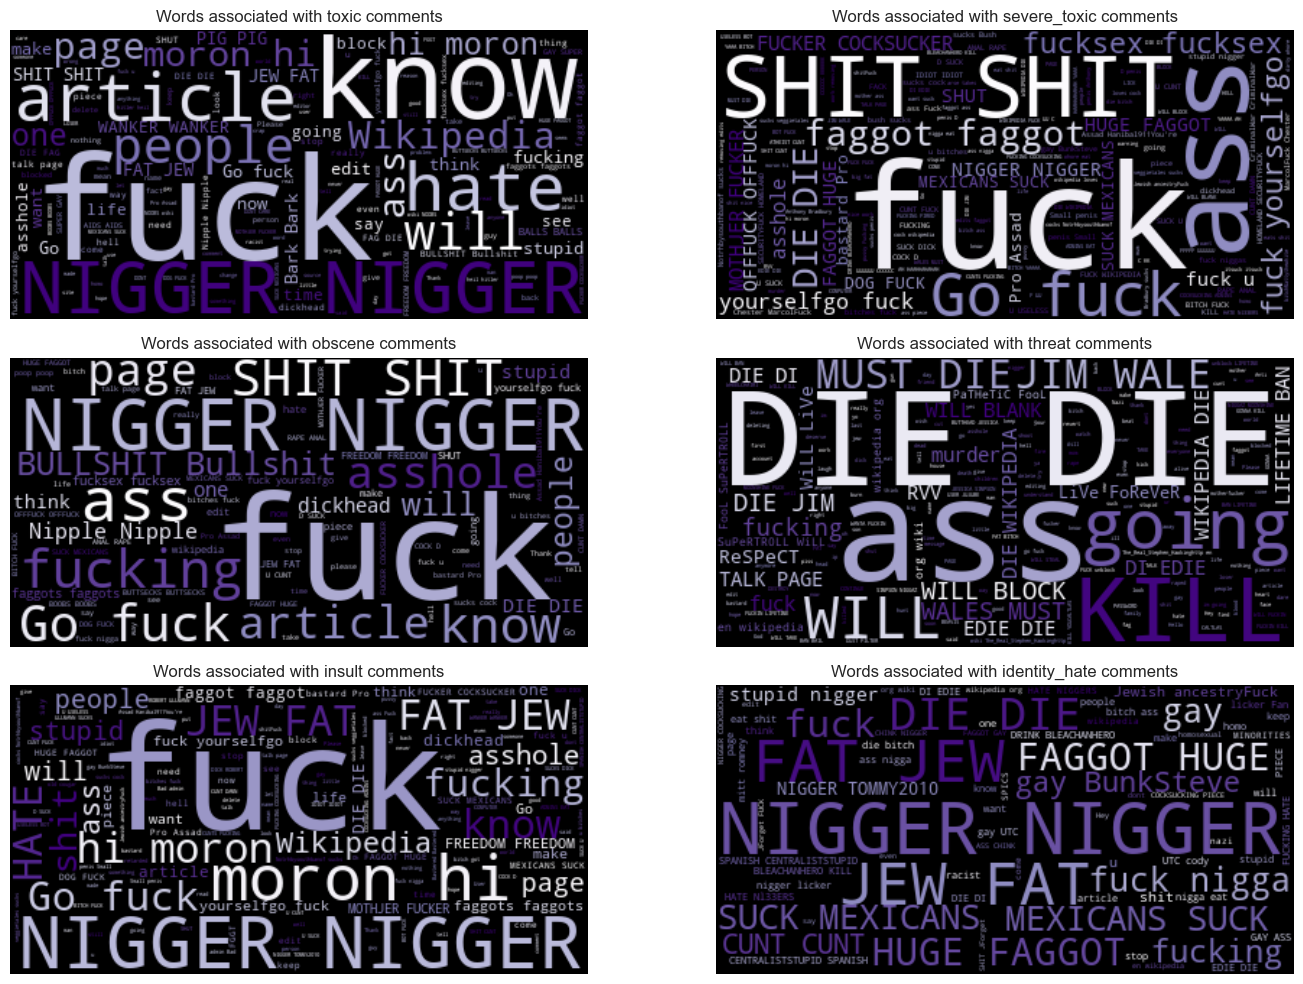

In [84]:
def visualize_word_clouds(labels, df):
    """
    Visualize the most common words contributing to each specified label.
    """
    rows = 3
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    for i, label in enumerate(labels):
        context = df[df[label] == 1]
        text = context.comment_text.str.cat(sep=' ')
        wordcloud = WordCloud(width=400, height=200, max_font_size=100, colormap="Purples").generate(text)
        row = i // 2
        col = i % 2
        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
        ax.imshow(wordcloud.recolor(colormap="Purples"), interpolation='bilinear')
        ax.axis("off")
        ax.set_title(f"Words associated with {label} comments", size=12)

    plt.tight_layout()
    plt.show()

labels_to_visualize = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
visualize_word_clouds(labels_to_visualize,train)


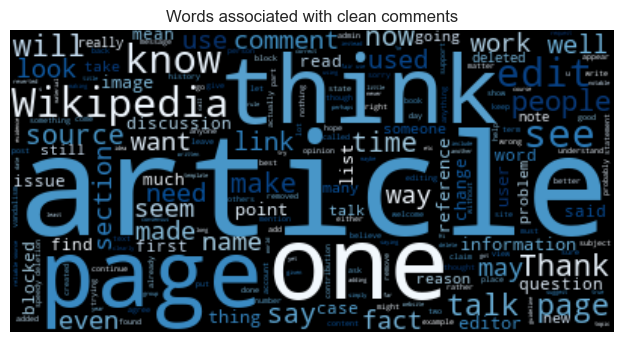

In [85]:
mask = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 0).all(axis=1)
train_clean = train[mask]
text = train_clean.comment_text.str.cat(sep=' ')
wordcloud = WordCloud(width=400, height=200, max_font_size=100, colormap="Blues").generate(text)
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Words associated with clean comments", size=12)
plt.tight_layout()
plt.show()


Now, with a good sense of the data, we are in a better position to process the data and subsequently build a predictive multilabel classification model. In summary, we have learnt of the short comment length, positive for a simple archhitecture like logistic Regression, as well as the class imbalance both with the non-toxic comments and within the toxic labels, indicating the need for wider evaluation metrics like AUC.

### Model Building

##### ⚙️ Text Preprocessing for Toxic Comments Classifier

Based on what we learnt, we adopt a series of text preprocessing steps to prepare the text data for appropriate classification to measure toxicity.

1. **Lowercasing:**
   - Converts the entire text to lowercase to ensure uniformity in representation.

2. **Emoji Replacement:**
   - Utilizes the `demoji` library to identify and replace emojis with their meanings.
   - This step is useful as emojis may carry sentiment or context, contributing to the overall understanding of the text.

3. **Stopword Removal:**
   - Eliminates common English stopwords (e.g., 'the', 'is', 'and') that may not contribute significantly to the classification task.
   
4. **Punctuation Removal:**
   - Removes punctuation marks to focus on word-level analysis and to prevent them from influencing the model's understanding of the text.

5. **Non-ASCII Character Removal:**
   - Filters out non-ASCII characters to ensure compatibility and consistency in subsequent processing steps.

6. **Numeric Character Removal:**
   - Eliminates numeric characters from the text as they might not contribute to the identification of toxic language.

7. **Whitespace Reduction:**
   - Consolidates consecutive whitespace characters into a single space to maintain a clean and standardized text format.

These preprocessing steps collectively aim to enhance the quality of the input text data, emphasizing relevant information while minimizing noise. This cleaner representation of text data can improve the effectiveness of subsequent models by highlighting significant patterns and features while discarding irrelevant details.


In [68]:
def preprocess_comments(input_text):
    text = input_text.lower()

    emoji_meanings = demoji.findall(text)
    for emoji_char, meaning in emoji_meanings.items():
        text = text.replace(emoji_char, f" {meaning} ")

    stop_words = set(stopwords.words("english"))
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join([x for x in words])

    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    text = ''.join([c for c in text if ord(c) < 128])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [106]:
train_x['comment_text'] = train_x['comment_text'].apply(preprocess_comments)
test_x['comment_text'] = test_x['comment_text'].apply(preprocess_comments)


/var/folders/66/w0v0bskn09z04kf6_8m9qyrw0000gn/T/ipykernel_7756/3351288084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['comment_text'] = train_x['comment_text'].apply(preprocess_comments)
/var/folders/66/w0v0bskn09z04kf6_8m9qyrw0000gn/T/ipykernel_7756/3351288084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['comment_text'] = test_x['comment_text'].apply(preprocess_comments)


In [5]:
import pickle

with open('train_x.pkl', 'wb') as file:
    pickle.dump(train_x, file)

with open('test_x.pkl', 'wb') as file:
    pickle.dump(test_x, file)


In [13]:
with open('train_x.pkl', 'rb') as file:
    train_x = pickle.load(file)

with open('test_x.pkl', 'rb') as file:
    test_x = pickle.load(file)


Next, we initialize a TF-IDF vectorizer with specific parameters, including Unicode stripping to standardize characters especially in multilingual contexts, word-level analysis where each word is treated as a separate feature, providing a more granular representation of the text, consideration of unigrams, bigrams, and trigrams to capture contextual information, and L2 normalization to ensure the same length for all vectors. Then, we fit the vectorizer on training data to learn the vocabulary and transforms the raw text fpr both trainig and test into TF-IDF vectors. These choices enhance the model's capacity to capture nuanced information from text while ensuring consistent feature representations and preventing biases between training and test datasets.

We opted for TF-IDF over CountVectorizer to mitigate the impact of frequently occurring tokens in a corpus, as these tokens might provide less informative features. TF-IDF combines CountVectorizer with TfidfTransformer, transforming a count matrix into a normalized representation. The goal is to downscale the influence of tokens that are prevalent across the corpus, focusing on features that are more discriminative. In our case, using TF-IDF has proven more effective than CountVectorizer, particularly in the context of Wikipedia talk page edits where common terms like "wiki," "Wikipedia," and "edit" are prevalent but may not contribute significantly to our classification objectives. This choice enhances accuracy by emphasizing more informative features.


In [10]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
x_train = vectorizer.fit_transform(train_x['comment_text'])
x_test = vectorizer.transform(test_x['comment_text'])

##### Model Choice

The model architecture for our text classification task involves shallow models including logistic regression, and Multinomial Naive Bayes (MNB) classifiers. The dataset is split into 70% training and 30% testing sets. We use the MultiOutputClassifier wrapper to handle multi-label classification. The logistic regression model is trained on the training dataset, and its performance is evaluated on the validation set. Similarly, the MNB model is trained and assessed on the same validation set. The choice of these classifiers aims to explore their suitability for the task, and the validation set is crucial for guiding the final decision.

Other hyperparameters are fine-tuned based on the validation set performance to optimize the chosen model before final evaluation on the test set.

##### Evaluation Metrics

Our evaluation metrics assess the performance of each model keeping in mind that the dataset is imbalanced with predominantly non-toxic comments. The classification report provides a detailed breakdown of precision, recall, and F1-score for each label, offering insights into how well the model handles different types of comments. While accuracy is computed, the emphasis is placed on weighted metrics—precision, recall, and F1 score—that consider class imbalances. These metrics provide a balanced evaluation, crucial in scenarios where the majority class (non-toxic) dominates. The inclusion of the weighted AUC-ROC further enhances the assessment, focusing on the model's ability to distinguish between toxic and non-toxic comments across different probability thresholds. 


In [35]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(predictions, labels, prob):
    target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    print("Classification Report:")
    report = classification_report(labels, predictions,target_names=target_names)
    print(report)

    accuracy = accuracy_score(labels, predictions)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    weighted_precision = precision_score(labels, predictions, average='weighted')
    weighted_recall = recall_score(labels, predictions, average='weighted')
    weighted_f1 = f1_score(labels, predictions, average='weighted')

    print(f'Weighted-Average Precision: {weighted_precision:.4f}')
    print(f'Weighted-Average Recall: {weighted_recall:.4f}')
    print(f'Weighted-Average F1 Score: {weighted_f1:.4f}')

    probabilities_2d = [array[:, 1] for array in prob]
    probabilities_2d = np.array(probabilities_2d).T 
    average_roc_auc = roc_auc_score(labels, probabilities_2d)
    weighted_average_roc_auc = roc_auc_score(labels, probabilities_2d, average='weighted')
    print(f'Average AUC-ROC: {average_roc_auc:.4f}')
    print(f'Weighted-Average AUC-ROC: {weighted_average_roc_auc:.4f}')

In [36]:
def cv_tf_train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)     
    lr = MultiOutputClassifier(LogisticRegression())
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    probabilities = lr.predict_proba(X_test)
    print("LogisticRegression:")
    evaluate_model(y_pred, y_test, probabilities)
    print()

    mnb = MultiOutputClassifier(MultinomialNB())
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    probabilities = mnb.predict_proba(X_test)
    print("MultinomialNB:")
    evaluate_model(y_pred, y_test, probabilities)
    print()
    
cv_tf_train_test(x_train, train_y)


LogisticRegression:
Classification Report:
               precision    recall  f1-score   support

        toxic       0.97      0.37      0.53      4582
 severe_toxic       0.65      0.10      0.18       486
      obscene       0.96      0.38      0.55      2556
       threat       0.00      0.00      0.00       136
       insult       0.86      0.28      0.42      2389
identity_hate       0.86      0.04      0.08       432

    micro avg       0.94      0.32      0.48     10581
    macro avg       0.72      0.20      0.29     10581
 weighted avg       0.91      0.32      0.47     10581
  samples avg       0.03      0.02      0.03     10581

Accuracy: 90.78%
Weighted-Average Precision: 0.9132
Weighted-Average Recall: 0.3202
Weighted-Average F1 Score: 0.4690
Average AUC-ROC: 0.9750
Weighted-Average AUC-ROC: 0.9692



/Users/emaanbilal/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emaanbilal/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emaanbilal/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users

MultinomialNB:
Classification Report:
               precision    recall  f1-score   support

        toxic       1.00      0.04      0.07      4582
 severe_toxic       0.00      0.00      0.00       486
      obscene       1.00      0.02      0.03      2556
       threat       0.00      0.00      0.00       136
       insult       1.00      0.00      0.00      2389
identity_hate       0.00      0.00      0.00       432

    micro avg       1.00      0.02      0.04     10581
    macro avg       0.50      0.01      0.02     10581
 weighted avg       0.90      0.02      0.04     10581
  samples avg       0.00      0.00      0.00     10581

Accuracy: 89.84%
Weighted-Average Precision: 0.9004
Weighted-Average Recall: 0.0196
Weighted-Average F1 Score: 0.0379
Average AUC-ROC: 0.8056
Weighted-Average AUC-ROC: 0.8289



/Users/emaanbilal/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emaanbilal/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emaanbilal/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users

The Logistic Regression model exhibits superior performance over the Multinomial Naive Bayes model in classifying toxic comments. It achieves a better balance between precision and recall, resulting in higher accuracy and weighted-average metrics. The model's discriminative ability, reflected in the higher AUC-ROC score, further supports its effectiveness. Given its consistent and robust performance across multiple evaluation metrics, Logistic Regression emerges as the preferred choice for toxic comments classification.

Now we decide to do grid search to seek for the "optimal" hyperparameters for the chosen model. Since we have 6 different labels, tuning the model for each label would be time consuming, so we will use the most common label "Toxic" to tune hyperparameters, which our EDA supports as the logical choice given that it dominates the observations in the training data.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

logistic_regression_classifier = LogisticRegression()

parameter_grid = {
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.001, 0.01, 0.1, 1],
    'class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 100}]  
}

cross_validation = StratifiedKFold(n_splits=3)

random_search = RandomizedSearchCV(
    logistic_regression_classifier,
    param_distributions=parameter_grid,
    n_iter=10, 
    cv=cross_validation,
    scoring='roc_auc',
    random_state=42,
)

random_search.fit(x_train, train_y['toxic'])

Following the model selection process, the chosen Logistic Regression model is trained on the entire training dataset using the optimized hyperparameters. This step is crucial to ensure that the model is well-equipped for its final evaluation on the test set, allowing it to generalize effectively to unseen data.

### 📌 Test Data Results

In [ ]:
lr_clf = MultiOutputClassifier(random_search.best_estimator_)

lr_clf.fit(x_train, train_y)
y_test_pred = lr_clf.predict(x_test)
y_test_prob = lr_clf.predict_proba(x_test)

In [49]:
import warnings
warnings.filterwarnings("ignore")

print("Test Set Results:")
evaluate_model(y_test_pred, test_y, y_test_prob)

Test Set Results:
Classification Report:
               precision    recall  f1-score   support

        toxic       0.36      0.95      0.52      6090
 severe_toxic       0.14      0.88      0.24       367
      obscene       0.38      0.92      0.54      3691
       threat       0.22      0.75      0.34       211
       insult       0.34      0.91      0.49      3427
identity_hate       0.25      0.80      0.38       712

    micro avg       0.34      0.92      0.49     14498
    macro avg       0.28      0.87      0.42     14498
 weighted avg       0.35      0.92      0.50     14498
  samples avg       0.06      0.09      0.07     14498

Accuracy: 76.33%
Weighted-Average Precision: 0.3459
Weighted-Average Recall: 0.9203
Weighted-Average F1 Score: 0.5014
Average AUC-ROC: 0.9734
Weighted-Average AUC-ROC: 0.9648


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


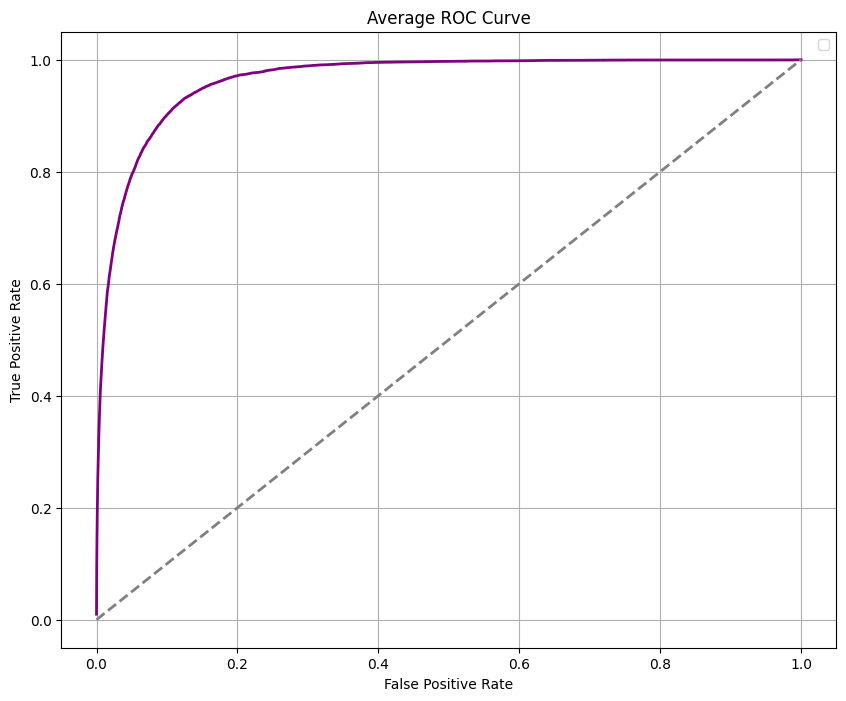

In [63]:
from sklearn.metrics import roc_curve, auc

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
test_y_array = test_y.to_numpy()
roc_auc = dict()
fpr = dict()
tpr = dict()
weights = [len(test_y[test_y.iloc[:, i] == 1]) / len(test_y) for i in range(len(target_names))]
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(test_y_array[:, i], y_test_prob[i][:, 1])  
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(target_names))]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(len(target_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) * weights[i]
mean_tpr /= np.sum(weights)
plt.figure(figsize=(10, 8))
plt.plot(all_fpr, mean_tpr, linestyle='-', linewidth=2, color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2) 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


### 📈 Understanding Results

The model exhibits strong recall for toxic, severe toxic, obscene, and insult classes, effectively identifying instances of these categories. However, precision is relatively low, resulting in a trade-off between minimizing false negatives and false positives. Notably, the model shows room for improvement in distinguishing threats and identity hate, where precision and recall are both moderate. The overall strong discrimination ability, reflected in high AUC-ROC scores, suggests the model's effectiveness in ranking instances by toxicity.

Analyzing the words misclassified by Logistic Classifier. Checking for 'threat' label with the lowest f1 score



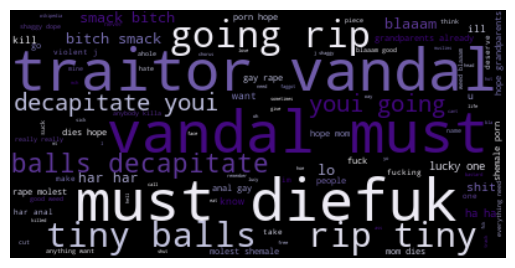

In [89]:
misclassified_indices = np.where((test_y['threat'] == 1) & (y_test_pred[:, 3] == 0))[0]
misclassified_texts = [test_x.iloc[index, 0] for index in misclassified_indices]
text = ' '.join(misclassified_texts)

wordcloud = WordCloud(width=400, height=200, max_font_size=100, colormap="Purples").generate(text)
plt.imshow(wordcloud.recolor(colormap="Purples"), interpolation='bilinear')
plt.axis('off')
plt.show()


This word cloud indicates that the model performed very poorly in categroizing threats that contained the word "vandal", or "traitor", pointing to the need for a more representative training set that includes these representations to allow for correct classification. 

To boost the classifier's performance, transitioning from TF-IDF to word embeddings can enhance its ability to capture semantic nuances. Further feature engineering, including spelling correction and sentiment scores, can deepen the model's comprehension of language nuances. Exploring advanced models like LightGBM and ensemble methods like stacking can leverage diverse strengths for improved predictions. Incorporating deep learning models, such as LSTM, enables a more nuanced understanding of sequential language patterns. Finally, advanced hyperparameter tuning, like Bayesian Optimization, ensures systematic optimization for enhanced accuracy. These strategic improvements collectively aim to fortify the classifier's proficiency in identifying toxic comments with increased accuracy and comprehensiveness.
